# Analyse processed Tweets

Problems:

- Commas within text make it difficult to read files > when preprocessing, add a special delimiter to mark the beginning and the start of the Tweet content

In [2]:
# Useful starting lines
%matplotlib inline
import copy
import numpy as np 
#import matplotlib as mpl
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import re
import glob
import ast
from datetime import datetime
from collections import Counter
import itertools
import nltk
nltk.download("stopwords")
from nltk import bigrams 
from nltk.corpus import stopwords
import string
import locale
import reverse_geocoder as rg
import multiprocessing as mp
import dask.dataframe as dd
locale.setlocale(locale.LC_TIME, "en_US.utf8")
%load_ext autoreload

[nltk_data] Downloading package stopwords to /home/servan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load and combine Data

In [37]:
#idea read whole line >  then parse
def load_csv_data_old(data_path, sub_sample=True):
    """Loads data and transforms it into a pandas dataframe"""
    
    #extracts tweet ID and timestamp
    tw1 = pd.read_csv(data_path,sep=",",usecols=[0,1],encoding = "ISO-8859-1",header=None)
    
    #extracts tweet content
    #tw2 = pd.read_csv(data_path,sep="[0-9],|,\"\[",usecols=[2],encoding = "ISO-8859-1",header=None,engine="python")
    
    #extract coordinates & location tag
    #tw3 = pd.read_csv(data_path,sep=",\"\[|\]\",",usecols=[1,2],encoding = "ISO-8859-1",header=None,engine="python")
    
    #merge everything
    #tw = pd.concat((tw1,tw2,tw3),axis=1)
    
    #extract complete string per row
    tw = pd.read_csv(data_path,sep="NotADelimiter",usecols=[0,1],encoding = "ISO-8859-1",header=None,engine="python")  
    
    #extract tweet ID and timestamp
    s = tw[0].apply(lambda x: x.split(","))
    tw["id"] = s.apply(lambda x: x[0])
    tw["time"] = s.apply(lambda x: x[1] if len(x) > 1 else None)
    
    #extract tweet content
    s = tw[0].apply(lambda x: re.split("[0-9],|,\"\[",x))
    tw["text"] = s.apply(lambda x: x[2] if len(x) > 2 else None)
    
    #extract coordinates & location tag
    s = tw[0].apply(lambda x: re.split(",\"\[|\]\",",x))
    tw["coord"] = s.apply(lambda x: x[1] if len(x)> 1 else None)
    tw["loc_tag"] = s.apply(lambda x: x[2] if len(x) > 2 else None)
    #tw3 = pd.read_csv(data_path,sep=",\"\[|\]\",",usecols=[1,2],encoding = "ISO-8859-1",header=None,engine="python")
    
    
    # sub-sample
    if sub_sample:
        tw = tw[::50]
    return tw

def load_csv_data(data_path, sub_sample=False):
    """Loads data and transforms it into a pandas dataframe"""
    
    #extracts tweet ID and timestamp
    tw = pd.read_csv(data_path,encoding = "ISO-8859-1",header=None,engine="python")
    print(data_path)
    # sub-sample
    if sub_sample:
        tw = tw[::50]
    return tw

"""Read all files in Data directory, load & parse them and concatenate resulting DataFrames"""
#files = glob.glob('./Data/*.csv')
files = glob.glob('/mount/SDF/Dump2/*.csv')
tw = pd.DataFrame
first = True
for data_path in files:
    tw_temp = load_csv_data(data_path=data_path, sub_sample=True)
    if first:
        tw = tw_temp
        first = False
    else:
        tw = pd.concat((tw,tw_temp),axis=0,ignore_index=False)
tw.index = range(0,np.shape(tw)[0])
tw.columns = ["id","time","text","coord","loc_tag"]

In [38]:
files = glob.glob('/mount/SDF/Dump2/*.csv')
files = files[0:50]

if __name__ == '__main__':
    p = mp.Pool(mp.cpu_count()-2)
    pandas_list = p.map(load_csv_data, files)
    print("End")

tw = pd.concat(pandas_list,axis=0,ignore_index=False)
tw.index = range(0,np.shape(tw)[0])
tw.columns = ["id","time","text","coord","loc_tag"]

/mount/SDF/Dump2/tweets2015123113.csv
/mount/SDF/Dump2/tweets2015042910.csv
/mount/SDF/Dump2/tweets2016012910.csv
/mount/SDF/Dump2/tweets2015081208.csv
/mount/SDF/Dump2/tweets2015062815.csv
/mount/SDF/Dump2/tweets2015031006.csv
/mount/SDF/Dump2/tweets2016091512.csv
/mount/SDF/Dump2/tweets2016092707.csv
/mount/SDF/Dump2/tweets2016082816.csv
/mount/SDF/Dump2/tweets2015060819.csv
/mount/SDF/Dump2/tweets2015082006.csv
/mount/SDF/Dump2/tweets2015050316.csv
/mount/SDF/Dump2/tweets2016070119.csv
/mount/SDF/Dump2/tweets2016082802.csv
/mount/SDF/Dump2/tweets2016050221.csv
/mount/SDF/Dump2/tweets2016061401.csv
/mount/SDF/Dump2/tweets2015080121.csv
/mount/SDF/Dump2/tweets2016081704.csv
/mount/SDF/Dump2/tweets2015121602.csv
/mount/SDF/Dump2/tweets2016061519.csv
/mount/SDF/Dump2/tweets2016050707.csv
/mount/SDF/Dump2/tweets2015123014.csv
/mount/SDF/Dump2/tweets2015040506.csv
/mount/SDF/Dump2/tweets2015050114.csv
/mount/SDF/Dump2/tweets2015021300.csv
/mount/SDF/Dump2/tweets2016053008.csv
/mount/SDF/D

In [39]:
tw
tw.to_pickle("PickledTweets_large.pkl")
#tw.to_pickle("PickledTweets.pkl")

In [40]:
tw = pd.read_pickle("PickledTweets_large.pkl")
tw

,id,time,text,coord,loc_tag
0,776376269281849344,Thu Sep 15 11:05:01 +0000 2016,@julietchiapell0 thanks Juliet!!,"[[[-77.479597, 38.802143], [-77.479597, 38.880...",place
1,776376270175232000,Thu Sep 15 11:05:01 +0000 2016,last night was pretty rad and now i'm a cute b...,"[[[-82.728681, 27.808138], [-82.728681, 27.826...",place
2,776376270338793473,Thu Sep 15 11:05:01 +0000 2016,@badgalbree_ kys you better not go to no just...,"[[[-76.5714, 38.237077], [-76.5714, 38.32277],...",place
3,776376270716215296,Thu Sep 15 11:05:01 +0000 2016,Breaking bad is so bad ass I've been watching ...,"[[[-97.233811, 32.586565], [-97.233811, 32.817...",place
4,776376270103904256,Thu Sep 15 11:05:01 +0000 2016,Hoy es 15 de septiembre día de la Independenci...,"[[[-73.603756, 40.624428], [-73.603756, 40.673...",place
5,776376271097827328,Thu Sep 15 11:05:02 +0000 2016,I'm in one spot all day dm me to get some gear...,"[[[-77.119401, 38.801826], [-77.119401, 38.995...",place
6,776376271882358785,Thu Sep 15 11:05:02 +0000 2016,@gktrocks Good Morning Griff! I hope all Rocks...,"[[[-74.026675, 40.683935], [-74.026675, 40.877...",place
7,776376271718744064,Thu Sep 15 11:05:02 +0000 2016,@yoitskylah @Kennedy626 @_rileysarah @AlphaAce...,"[[[-85.605166, 30.355644], [-85.605166, 35.000...",place
8,776376271861379072,Thu Sep 15 11:05:02 +0000 2016,Truly Blessed to see 17!!,"[[[-73.727776, 40.950918], [-73.727776, 42.050...",place
9,776376272398188544,Thu Sep 15 11:05:02 +0000 2016,Looking like shit for picture day!,"[[[-81.530955, 41.276868], [-81.530955, 41.350...",place


map
oder
mapasync
pool.map
multiprocessing 
pool
mapaysnc

https://github.com/epfml/sent2vec/blob/master/get_sentence_embeddings_from_pre-trained_models.ipynb

gridsearch.cv > scikitlearn

In [41]:
#transform string coordinates into floats
dtw_coord = dd.from_pandas(tw["coord"], npartitions=mp.cpu_count()-1)
dtw_coord = dtw_coord.map(lambda x: re.findall(r"[-+]?\d*\.\d+|\d+",x) if isinstance(x,str) else None)
tw["coord"] = dtw_coord.map(lambda x: [float(i) for i in x] if isinstance(x,list) else None).compute()
#remove list comprehension > 

In [14]:
#tw["coord"] = tw["coord"].apply(lambda x: re.findall(r"[-+]?\d*\.\d+|\d+",x) if isinstance(x,str) else None)
#tw["coord"] = tw["coord"].apply(lambda x: [float(i) for i in x] if isinstance(x,list) else None)

In [42]:
"""assign a single coordinate to rows with location tag "place"""
indx = tw["loc_tag"]=="place"
tw_place = dd.from_pandas(tw[indx]["coord"],npartitions=mp.cpu_count()-1)
#tw_place = tw_place.apply(lambda x: x.replace("\"",""))
#tw_place =tw_place.apply(lambda x: ast.literal_eval(x))

#calculate the mean of the coordinates given; 
#because the coordinates are very close to each other, we can treat the surface as flat
def calc_mean(x):
    if x == None:
        return(None)
    else:
        lons = [x[i] for i in range(0,len(x),2)]
        lats = [x[i] for i in range(1,len(x),2)]
    lon = np.mean(lons)
    lat = np.mean(lats)
    return([lon,lat])

tw_place = tw_place.map(calc_mean,meta=tw_place)
tw.loc[indx,"coord"] = tw_place.compute()

In [43]:
#convert time strings to datetime formate
#tw["time"] = tw["time"].apply(lambda x: re.sub("\+0000\s","",str(x)) if re.search("\+0000\s",str(x)) else None)
#tw["time"] = tw["time"].apply(lambda x: datetime.strptime(x,"%a %b %d %H:%M:%S %Y") if isinstance(x,str) else None)
dtw_time = dd.from_pandas(tw["time"], npartitions=mp.cpu_count()-1)
dtw_time = dtw_time.map(lambda x: re.sub("\+0000\s","",str(x)) if re.search("\+0000\s",str(x)) else None,meta=dtw_time)
tw["time"] = dtw_time.map(lambda x: datetime.strptime(x,"%a %b %d %H:%M:%S %Y") if isinstance(x,str) else None,meta=dtw_time).compute()

In [17]:
#convert id-string to int
#tw["id"] = tw["id"].apply(lambda x: float(x) if re.search("^[0-9]{18}$",x) else None)

In [44]:
#remove first colum with full row
#del tw[0]

def find_nones(df):
    indices = df.apply(lambda x: False if x.isnull().any() else True,axis=1)
    return(indices)


#remove all rows which contain None in any row
dtw_missing = dd.from_pandas(tw,npartitions=mp.cpu_count()-1)
indx = dtw_missing.map_partitions(find_nones,meta=(None,"bool"))
tw = tw[indx.compute()]
print("Removed a total of "+ str(sum(~indx.compute())) + " rows")
tw.index = range(0,np.shape(tw)[0])

Removed a total of 23304 rows


Removed a total of 23304 rows


In [45]:
tw

,id,time,text,coord,loc_tag
0,776376269281849344,2016-09-15 11:05:01,@julietchiapell0 thanks Juliet!!,"[-77.438513, 38.841163]",place
1,776376270175232000,2016-09-15 11:05:01,last night was pretty rad and now i'm a cute b...,"[-82.7184075, 27.8172385]",place
2,776376270338793473,2016-09-15 11:05:01,@badgalbree_ kys you better not go to no just...,"[-76.5136315, 38.2799235]",place
3,776376270716215296,2016-09-15 11:05:01,Breaking bad is so bad ass I've been watching ...,"[-97.1356375, 32.70185]",place
4,776376270103904256,2016-09-15 11:05:01,Hoy es 15 de septiembre día de la Independenci...,"[-73.5842655, 40.648987]",place
5,776376271097827328,2016-09-15 11:05:02,I'm in one spot all day dm me to get some gear...,"[-77.0143985, 38.898603]",place
6,776376271882358785,2016-09-15 11:05:02,@gktrocks Good Morning Griff! I hope all Rocks...,"[-73.9685415, 40.780709]",place
7,776376271718744064,2016-09-15 11:05:02,@yoitskylah @Kennedy626 @_rileysarah @AlphaAce...,"[-83.1738665, 32.6782075]",place
8,776376271861379072,2016-09-15 11:05:02,Truly Blessed to see 17!!,"[-72.757385, 41.500753]",place
9,776376272398188544,2016-09-15 11:05:02,Looking like shit for picture day!,"[-81.49715, 41.3135005]",place


In [51]:
#switch lat & lon position to work with reverse geocoder
#tw["coord"] = tw["coord"].apply(lambda x: [x[1],x[0]] if len(x)>1 else None)
tw["coord"] = dd.from_pandas(tw["coord"],npartitions=mp.cpu_count()-1).map(lambda x: [x[1],x[0]]).compute()

In [52]:
#still getting too many open files error
#get state location for each tweet
def state_lookup(x):
    coords =[(i,j) for i,j in x.values.flatten()]
    loc_info = rg.search(coords)
    states = [i["admin1"] for i in loc_info]
    #state = loc_info[0]["admin1"]
    return(states)

def state_lookup(x):
    coords =[(i,j) for i,j in x.values.flatten()]
    loc_info = rg.search(coords)
    states = [i["admin1"] for i in loc_info]
    #state = loc_info[0]["admin1"]
    return(states)

#tw["state"] = state_lookup(tw["coord"])
#geo = rg.RGeocoder(mode=2, verbose=True, stream=io.StringIO(open('custom_source.csv', encoding='utf-8').read()))

In [53]:
#dtw_coords = dd.from_pandas(tw["coord"],npartitions=mp.cpu_count()-1)
import time
start_time = time.time()
tw["state"] = state_lookup(tw["coord"])
elapsed_time = time.time() - start_time
#tw["state"] = dtw_coords.map_partitions(state_lookup,meta=dtw_coords).compute()

In [54]:
elapsed_time

16.151214361190796

In [16]:
tw
#del tw["bigrams"]
tw.to_pickle("PickledTweets_large_states_big.pkl")

In [3]:
tw = pd.read_pickle("PickledTweets_large_states_big.pkl")
tw

,id,time,text,coord,loc_tag,state
0,776376269281849344,2016-09-15 11:05:01,@julietchiapell0 thanks Juliet!!,"[38.841163, -77.438513]",place,Virginia
1,776376270175232000,2016-09-15 11:05:01,last night was pretty rad and now i'm a cute b...,"[27.8172385, -82.7184075]",place,Florida
2,776376270338793473,2016-09-15 11:05:01,@badgalbree_ kys you better not go to no just...,"[38.2799235, -76.5136315]",place,Maryland
3,776376270716215296,2016-09-15 11:05:01,Breaking bad is so bad ass I've been watching ...,"[32.70185, -97.1356375]",place,Texas
4,776376270103904256,2016-09-15 11:05:01,Hoy es 15 de septiembre día de la Independenci...,"[40.648987, -73.5842655]",place,New York
5,776376271097827328,2016-09-15 11:05:02,I'm in one spot all day dm me to get some gear...,"[38.898603, -77.0143985]",place,"Washington, D.C."
6,776376271882358785,2016-09-15 11:05:02,@gktrocks Good Morning Griff! I hope all Rocks...,"[40.780709, -73.9685415]",place,New York
7,776376271718744064,2016-09-15 11:05:02,@yoitskylah @Kennedy626 @_rileysarah @AlphaAce...,"[32.6782075, -83.1738665]",place,Georgia
8,776376271861379072,2016-09-15 11:05:02,Truly Blessed to see 17!!,"[41.500753, -72.757385]",place,Connecticut
9,776376272398188544,2016-09-15 11:05:02,Looking like shit for picture day!,"[41.3135005, -81.49715]",place,Ohio


In [7]:
idx = tw["loc_tag"]=="geo"

In [8]:
tw["coord"][idx]

Series([], Name: coord, dtype: object)

In [57]:
from nltk import TweetTokenizer
#from sent2vec
tknzr1 = TweetTokenizer()
def tokenize(sentence, tknzr=tknzr1,to_lower=True):
    """Arguments:
        - tknzr: a tokenizer implementing the NLTK tokenizer interface
        - sentence: a string to be tokenized
        - to_lower: lowercasing or not
    """
    sentence = sentence.strip()
    sentence = ' '.join([format_token(x) for x in tknzr.tokenize(sentence)])
    if to_lower:
        sentence = sentence.lower()
    sentence = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))','<url>',sentence) #replace urls by <url>
    sentence = re.sub('(\@[^\s]+)','<user>',sentence) #replace @user268 by <user>
    filter(lambda word: ' ' not in word, sentence)
    return sentence

def format_token(token):
    """"""
    if token == '-LRB-':
        token = '('
    elif token == '-RRB-':
        token = ')'
    elif token == '-RSB-':
        token = ']'
    elif token == '-LSB-':
        token = '['
    elif token == '-LCB-':
        token = '{'
    elif token == '-RCB-':
        token = '}'
    return token

In [58]:
dtw_tokens= dd.from_pandas(tw["text"], npartitions=mp.cpu_count()-1)
dtw_tokens = dtw_tokens.map(tokenize, meta=dtw_tokens)
tw["tokenised"] = dtw_tokens.compute()

In [60]:
tw
#del tw["bigrams"]
tw.to_pickle("PickledTweets_large_states_big_tokenised.pkl")

In [9]:
tokens = pd.read_pickle("PickledTweets_large_states_big_tokenised.pkl")
tokens["tokenised"]


,id,time,text,coord,loc_tag,state,tokenised
0,776376269281849344,2016-09-15 11:05:01,@julietchiapell0 thanks Juliet!!,"[38.841163, -77.438513]",place,Virginia,<user> thanks juliet ! !
1,776376270175232000,2016-09-15 11:05:01,last night was pretty rad and now i'm a cute b...,"[27.8172385, -82.7184075]",place,Florida,last night was pretty rad and now i'm a cute b...
2,776376270338793473,2016-09-15 11:05:01,@badgalbree_ kys you better not go to no just...,"[38.2799235, -76.5136315]",place,Maryland,<user> kys you better not go to no justin brib...
3,776376270716215296,2016-09-15 11:05:01,Breaking bad is so bad ass I've been watching ...,"[32.70185, -97.1356375]",place,Texas,breaking bad is so bad ass i've been watching ...
4,776376270103904256,2016-09-15 11:05:01,Hoy es 15 de septiembre día de la Independenci...,"[40.648987, -73.5842655]",place,New York,hoy es 15 de septiembre día de la independenci...
5,776376271097827328,2016-09-15 11:05:02,I'm in one spot all day dm me to get some gear...,"[38.898603, -77.0143985]",place,"Washington, D.C.",i'm in one spot all day dm me to get some gear...
6,776376271882358785,2016-09-15 11:05:02,@gktrocks Good Morning Griff! I hope all Rocks...,"[40.780709, -73.9685415]",place,New York,<user> good morning griff ! i hope all rocks w...
7,776376271718744064,2016-09-15 11:05:02,@yoitskylah @Kennedy626 @_rileysarah @AlphaAce...,"[32.6782075, -83.1738665]",place,Georgia,<user> <user> <user> <user> me too
8,776376271861379072,2016-09-15 11:05:02,Truly Blessed to see 17!!,"[41.500753, -72.757385]",place,Connecticut,truly blessed to see 17 ! !
9,776376272398188544,2016-09-15 11:05:02,Looking like shit for picture day!,"[41.3135005, -81.49715]",place,Ohio,looking like shit for picture day !


In [10]:
tokens["tokenised"]

0                                   <user> thanks juliet ! !
1          last night was pretty rad and now i'm a cute b...
2          <user> kys you better not go to no justin brib...
3          breaking bad is so bad ass i've been watching ...
4          hoy es 15 de septiembre día de la independenci...
5          i'm in one spot all day dm me to get some gear...
6          <user> good morning griff ! i hope all rocks w...
7                         <user> <user> <user> <user> me too
8                                truly blessed to see 17 ! !
9                        looking like shit for picture day !
10                             these hoes ain't your friends
11         8 am classes thursday and mandatory gym time f...
12                                               feels <url>
13         slow hand clap for <user> at <user> this am fo...
14                                   some uselees bump <url>
15         <url> is in a spider hole recently vacuumed ye...
16         <user> é rela

In [71]:
use_cols = ["tokenised"]
filename = "tw_large_sentences.txt"
with open(filename,'w') as outfile:
    tw.to_string(outfile,columns=use_cols)

## Read text file with sentence vector

In [6]:
read_file = "~/sent2vec/vectorised_sentences.txt"
vec_sent = pd.read_csv(read_file, sep=" ", header=None)

In [15]:
vec_sent = vec_sent.loc[0:4000000,:]

In [8]:
vec_sent.to_pickle("vec_sent_4m.pkl")
vec_sent

,0,1,2,3,4,5,6,7,8,9,...,691,692,693,694,695,696,697,698,699,700
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1,-0.228920,-0.011085,-0.118330,0.110070,-0.171180,0.255810,-0.184450,-0.078979,-0.313170,-0.007866,...,-0.215450,-0.136050,-0.137410,-0.197610,-0.378100,-0.288470,-0.009192,-0.022358,-0.305020,NaN
2,-0.068295,0.083223,0.006091,-0.062280,-0.096821,0.077772,0.031682,0.165680,-0.064688,-0.080400,...,0.096416,-0.025053,0.032431,-0.111040,-0.003132,-0.073962,0.049476,-0.028385,-0.071172,NaN
3,-0.105770,-0.162110,0.179520,-0.089855,-0.056543,0.054632,-0.065880,-0.122650,-0.133870,-0.096578,...,-0.184900,0.098573,-0.046791,-0.144410,-0.073196,-0.085059,-0.101970,0.082638,-0.047331,NaN
4,-0.036480,0.036188,-0.043832,0.035701,-0.063674,0.163410,-0.117860,0.099406,-0.083573,-0.306800,...,0.116660,-0.139250,-0.221780,-0.138370,-0.065492,0.034897,0.056115,0.058556,-0.067837,NaN
5,-0.031676,0.282060,-0.179690,0.217730,0.167860,0.045774,0.043280,0.454980,0.023582,-0.134420,...,-0.204400,-0.022884,0.178950,-0.079366,-0.300200,-0.011448,-0.043911,-0.285490,-0.092163,NaN
6,0.017729,0.012803,-0.076673,-0.017672,-0.064711,0.065546,0.024125,0.111340,0.005053,-0.083017,...,-0.080103,-0.059594,0.055684,-0.168900,-0.079128,-0.069662,-0.066770,0.124230,0.022378,NaN
7,-0.041017,0.194870,-0.231420,-0.117840,-0.000796,0.130670,-0.097390,-0.032778,-0.149750,0.031717,...,0.006367,0.007220,-0.041312,-0.085666,0.085425,-0.087579,0.140930,-0.019730,-0.004152,NaN
8,-0.033059,0.051477,-0.018367,-0.039876,-0.045761,0.121850,-0.020063,0.030889,-0.140060,-0.096144,...,0.006391,0.106390,-0.132840,-0.151230,0.022477,-0.182190,0.000033,-0.076487,-0.061352,NaN
9,-0.087181,0.283040,-0.017875,-0.145440,-0.095015,0.055309,-0.146650,0.002319,-0.181630,-0.115980,...,-0.179350,0.198660,0.174280,-0.211300,0.122940,-0.133450,-0.156470,-0.040925,-0.114070,NaN


In [11]:
tw = tw.loc[0:4000000,:]
tw = tw["state"]
tw

0                  Virginia
1                   Florida
2                  Maryland
3                     Texas
4                  New York
5          Washington, D.C.
6                  New York
7                   Georgia
8               Connecticut
9                      Ohio
10                  Florida
11                  Ontario
12                Tennessee
13                 Kentucky
14                 Illinois
15                    Maine
16            Massachusetts
17                     Ohio
18           South Carolina
19                  Florida
20                 Missouri
21               New Jersey
22                     Utah
23                  Florida
24           North Carolina
25           South Carolina
26                  Georgia
27                 Delaware
28                 Coahuila
29                 New York
                 ...       
3999971          Washington
3999972               Texas
3999973             Florida
3999974              Nevada
3999975      South C

In [12]:
tw.to_pickle("states_4m.pkl")

In [11]:
y_start = pd.read_pickle("states_4m.pkl")

In [51]:
#Y = y_start.loc[0:2000000]
Y = y_start.loc[0:2000000]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y)
list(le.classes_)
Y = le.transform(Y) 

In [5]:
x_start = pd.read_pickle("vec_sent_4m.pkl")

In [52]:
#X = x_start.loc[0:2000000,0:699]
X = x_start.loc[0:2000000,0:699]

In [53]:
print(np.shape(Y))
print(np.shape(X))

(2000001,)
(2000001, 700)


## Build classification model

In [73]:
#http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]


assign a single coordinate to rows with location tag "place


In [86]:
linearly_separable

(array([[-0.17749658,  0.93049627],
        [ 1.97742406,  1.76615529],
        [ 1.80002379,  1.7003428 ],
        [-0.77083686,  2.35916348],
        [-0.30800901,  1.59406316],
        [ 0.61472141,  2.43489824],
        [ 1.0909431 ,  2.21663402],
        [-0.83488954,  2.35868875],
        [ 2.47946499,  1.33418967],
        [ 1.19926597,  1.82681392],
        [ 2.18506184,  0.8226875 ],
        [ 1.68423203,  1.0411311 ],
        [ 1.14621135,  2.07048527],
        [ 1.35596945,  0.56802498],
        [ 1.38520748,  1.82607238],
        [ 1.86729217,  1.18692699],
        [ 0.31227376,  2.24605353],
        [-0.08183484,  1.70065511],
        [ 0.90484472,  2.60683016],
        [-0.4358609 ,  2.0151414 ],
        [ 0.81441196,  2.13546784],
        [ 3.10874312,  2.26786504],
        [-0.25574217,  1.71281146],
        [ 1.88663027,  2.72089513],
        [ 2.29503547,  3.89267759],
        [-0.11415626,  0.85593357],
        [ 1.69703537,  3.47717799],
        [ 1.83855775,  0.926

/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


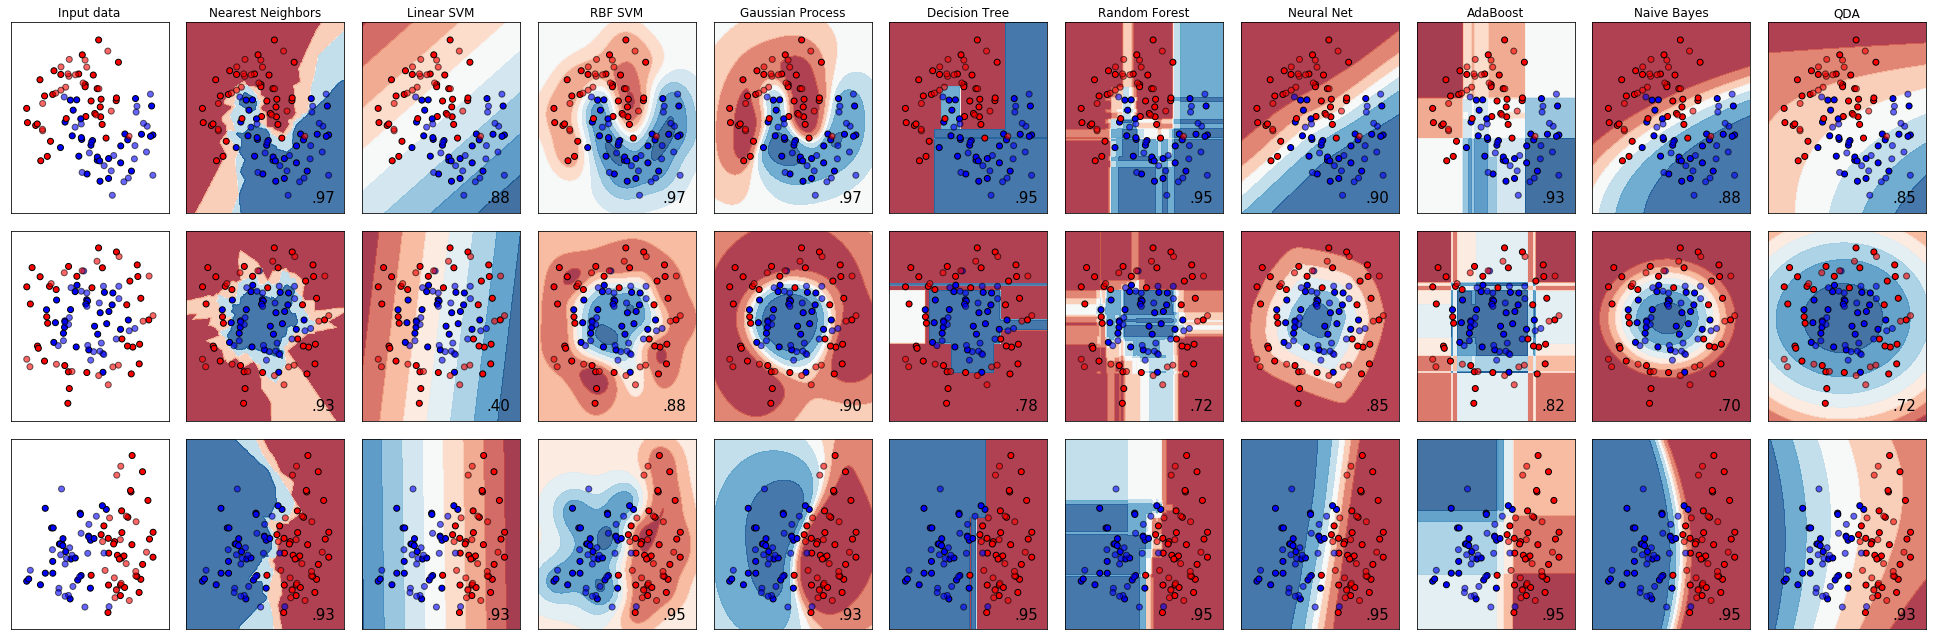

In [85]:
figure = plt.figure(figsize=(27, 9))
i = 1
datasets = list([X,Y])
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import multiprocessing as mp
# load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
#X = array[:,0:8]
#Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
#models.append(('LR', LogisticRegression(n_jobs=mp.cpu_count()-2)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_jobs=mp.cpu_count()-2)))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
models.append(('RF',RandomForestClassifier(max_depth=10, n_estimators=50, max_features=1,n_jobs=mp.cpu_count()-2)))
models.append(('SVM', LinearSVC()))
import time
start_time = time.time()

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
i = 1
for name, model in models:
    print(i)
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=2, random_state=seed)
    print(i)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    print(i)
    elapsed_time = time.time() - start_time
    print(elapsed_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    i = i+1
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
#plt.show()
plt.savefig("AlgoComparison_LR_LDA_KNN_RF_SVM_2m.pdf")
elapsed_time = time.time() - start_time

1
1


In [32]:
elapsed_time

263.80534291267395

In [45]:
current_name = "results_LR_LDA_KNN_RF_SVM_2m"
with open(current_name, 'wb') as fp:
        pickle.dump(results, fp)

In [46]:
with open ('outfile', 'rb') as fp:
    itemlist = pickle.load(fp)

In [50]:
cv_results

array([ 0.04259148,  0.0392    ])

Mit 10k & 700 param
1
1
1
84.47634196281433
LR: 0.057694 (0.000506)
2
2
2
8.625514507293701
LDA: 0.047495 (0.000705)
3
3
3
14.21036171913147
KNN: 0.044295 (0.002095)
4
4
4
63.707021713256836
CART: 0.043796 (0.003004)
5
5
5
178.2500023841858
NB: 0.033197 (0.001197)
6
6
6
3.873825788497925
RF: 0.085392 (0.004008)
7
7
7
94.9027304649353
SVM: 0.040896 (0.001696)


mit 10k un 300 param
1
1
1
13.336031436920166
LR: 0.069493 (0.001907)
2
2
2
0.30505847930908203
LDA: 0.047896 (0.004504)
3
3
3
6.017843961715698
KNN: 0.044695 (0.001895)
4
4
4
12.997028589248657
CART: 0.041096 (0.000504)
5
5
5
0.8044843673706055
NB: 0.033197 (0.001597)
6
6
6
1.2409021854400635
RF: 0.081592 (0.001208)
7
7
7
42.878971099853516
SVM: 0.047296 (0.002504)


1
LR: 0.110855 (0.055624)
2

/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)

LDA: 0.100735 (0.048121)
3
KNN: 0.065485 (0.026010)
4
CART: 0.056735 (0.013554)
5
NB: 0.006275 (0.001820)
6


# Not Used

In [19]:
#Tokenize & Count tokens in tweet text
#from https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False,stopwords_rm=False,**kwargs):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    if stopwords_rm:
        tokens = [token for token in tokens if token not in kwargs["stop_words"]]
    return tokens

In [20]:
dtw_tokens= dd.from_pandas(tw["text"], npartitions=mp.cpu_count()-1)
dtw_tokens = dtw_tokens.map(preprocess,True,meta=dtw_tokens)
#tw["tokens"] = tw["text"].apply(preprocess,lowercase=True)
tw["tokens"] = dtw_tokens.compute()

/home/servan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [21]:
#Count occurrence of each word
counts = Counter(itertools.chain.from_iterable(tw["tokens"]))

In [22]:
counts

Counter({'#addmeonsnapchat': 1,
         'https://t.co/URaNlqaA1O': 1,
         '@NBAMemes': 5,
         'Accidente': 1,
         'https://t.co/CFpq2ypVNV': 1,
         '@M_J_P_C_': 2,
         '@suttygal': 5,
         '@vaderband': 1,
         '@jihyewisdom1': 3,
         'http://t.co/MZcdZ3CkP1': 1,
         'CPort': 1,
         'VALEZQUEZ': 1,
         'https://t.co/03orOiETXp': 1,
         'https://t.co/FznFAYLxi1': 1,
         'https://t.co/pcvrLAlWiV': 1,
         '@FlyGuyJee': 1,
         '@Youlikeunique': 1,
         '#smartMONEY': 1,
         '@aysiarias': 1,
         '30.217': 1,
         '@dhoodenpyle2': 1,
         '@scotch_trooper': 2,
         '#SUGARLOAFKEY': 1,
         'https://t.co/iiks7ESCYK': 1,
         'tambieeeen': 1,
         '@AlyssaLynette1': 1,
         '@MeghanMess': 1,
         '#Lumira': 1,
         '@tralenlove': 5,
         'https://t.co/B8LQTy4Huc': 1,
         'Squaw': 14,
         '@matia_nargi': 2,
         'https://t.co/3LPAUDWzyo': 1,
         'Cal

In [23]:
#remove punctuation and stopwords
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']
#tw["tokens_stop"] = tw["text"].apply(preprocess,lowercase=True,
                              #stopwords_rm = True, stop_words=stop)

dtw_tokens= dd.from_pandas(tw["text"], npartitions=mp.cpu_count()-1)
dtw_tokens = dtw_tokens.map(preprocess,(True,True, stop), meta=dtw_tokens)
tw["tokens_stop"] = dtw_tokens.compute()

/home/servan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
tw

,id,time,text,coord,loc_tag,tokens,tokens_stop
0,776376269281849344,2016-09-15 11:05:01,@julietchiapell0 thanks Juliet!!,"[-77.438513, 38.841163]",place,"[@julietchiapell0, thanks, Juliet, !, !]","[@julietchiapell0, thanks, Juliet, !, !]"
1,776376270175232000,2016-09-15 11:05:01,last night was pretty rad and now i'm a cute b...,"[-82.7184075, 27.8172385]",place,"[last, night, was, pretty, rad, and, now, i'm,...","[last, night, was, pretty, rad, and, now, i'm,..."
2,776376270338793473,2016-09-15 11:05:01,@badgalbree_ kys you better not go to no just...,"[-76.5136315, 38.2799235]",place,"[@badgalbree_, kys, you, better, not, go, to, ...","[@badgalbree_, kys, you, better, not, go, to, ..."
3,776376270716215296,2016-09-15 11:05:01,Breaking bad is so bad ass I've been watching ...,"[-97.1356375, 32.70185]",place,"[Breaking, bad, is, so, bad, ass, I've, been, ...","[Breaking, bad, is, so, bad, ass, I've, been, ..."
4,776376270103904256,2016-09-15 11:05:01,Hoy es 15 de septiembre día de la Independenci...,"[-73.5842655, 40.648987]",place,"[Hoy, es, 15, de, septiembre, día, de, la, Ind...","[Hoy, es, 15, de, septiembre, día, de, la, Ind..."
5,776376271097827328,2016-09-15 11:05:02,I'm in one spot all day dm me to get some gear...,"[-77.0143985, 38.898603]",place,"[I'm, in, one, spot, all, day, dm, me, to, get...","[I'm, in, one, spot, all, day, dm, me, to, get..."
6,776376271882358785,2016-09-15 11:05:02,@gktrocks Good Morning Griff! I hope all Rocks...,"[-73.9685415, 40.780709]",place,"[@gktrocks, Good, Morning, Griff, !, I, hope, ...","[@gktrocks, Good, Morning, Griff, !, I, hope, ..."
7,776376271718744064,2016-09-15 11:05:02,@yoitskylah @Kennedy626 @_rileysarah @AlphaAce...,"[-83.1738665, 32.6782075]",place,"[@yoitskylah, @Kennedy626, @_rileysarah, @Alph...","[@yoitskylah, @Kennedy626, @_rileysarah, @Alph..."
8,776376271861379072,2016-09-15 11:05:02,Truly Blessed to see 17!!,"[-72.757385, 41.500753]",place,"[Truly, Blessed, to, see, 17, !, !]","[Truly, Blessed, to, see, 17, !, !]"
9,776376272398188544,2016-09-15 11:05:02,Looking like shit for picture day!,"[-81.49715, 41.3135005]",place,"[Looking, like, shit, for, picture, day, !]","[Looking, like, shit, for, picture, day, !]"


In [38]:
#create bigrams
#tw["bigrams"] = tw["tokens_stop"].apply(bigrams)
tw["bigrams"] = dd.from_pandas(tw["tokens_stop"],npartitions=mp.cpu_count()-1).map(bigrams).compute()

/home/servan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
tw

,id,time,text,coord,loc_tag,tokens,tokens_stop,bigrams
0,776376269281849344,2016-09-15 11:05:01,@julietchiapell0 thanks Juliet!!,"[-77.438513, 38.841163]",place,"[@julietchiapell0, thanks, Juliet, !, !]","[@julietchiapell0, thanks, Juliet, !, !]",<generator object bigrams at 0x7f5c845b9af0>
1,776376290500894720,2016-09-15 11:05:06,I can't choose a side. Man on The Moon make me...,"[-76.9924405, 38.752715]",place,"[I, can't, choose, a, side, ., Man, on, The, M...","[I, can't, choose, a, side, ., Man, on, The, M...",<generator object bigrams at 0x7f5c845b9c50>
2,776376318971809792,2016-09-15 11:05:13,"@Tavi59 saw him in Denver last year, Taj Mahal...","[-105.0639425, 40.5641905]",place,"[@Tavi59, saw, him, in, Denver, last, year, ,,...","[@Tavi59, saw, him, in, Denver, last, year, ,,...",<generator object bigrams at 0x7f5c845b9a40>
3,776376343990763520,2016-09-15 11:05:19,damn never seen a backflip on a dick https://t...,"[-75.117998, 40.0048655]",place,"[damn, never, seen, a, backflip, on, a, dick, ...","[damn, never, seen, a, backflip, on, a, dick, ...",<generator object bigrams at 0x7f5c845b97d8>
4,776376363460730880,2016-09-15 11:05:24,They time when the @Starbucks baristas not on...,"[-76.303738, 40.15251]",place,"[They, time, when, the, @Starbucks, baristas, ...","[They, time, when, the, @Starbucks, baristas, ...",<generator object bigrams at 0x7f5c845b9938>
5,776376386017718272,2016-09-15 11:05:29,@ConnValleyLax @ZimaGear nice work - as always...,"[-77.712567, 43.1626595]",place,"[@ConnValleyLax, @ZimaGear, nice, work, -, as,...","[@ConnValleyLax, @ZimaGear, nice, work, -, as,...",<generator object bigrams at 0x7f5c845b9728>
6,776376405907079169,2016-09-15 11:05:34,You stole my avi @MahoneyKelli,"[-89.2665075, 39.7393005]",place,"[You, stole, my, avi, @MahoneyKelli]","[You, stole, my, avi, @MahoneyKelli]",<generator object bigrams at 0x7f5c845b9678>
7,776376426245320704,2016-09-15 11:05:39,My pillow smells like @wild_hvnt95 and it's great,"[-83.0677285, 39.849473]",place,"[My, pillow, smells, like, @wild_hvnt95, and, ...","[My, pillow, smells, like, @wild_hvnt95, and, ...",<generator object bigrams at 0x7f5c845b9570>
8,776376442615504896,2016-09-15 11:05:42,already hit the snooze button 3 times this mor...,"[-83.804475, 27.698682]",place,"[already, hit, the, snooze, button, 3, times, ...","[already, hit, the, snooze, button, 3, times, ...",<generator object bigrams at 0x7f5c845b9360>
9,776376455781453833,2016-09-15 11:05:46,"If you're looking for work in #Orlando, FL, ch...","[-81.3792365, 28.5383355]",coordinates,"[If, you're, looking, for, work, in, #Orlando,...","[If, you're, looking, for, work, in, #Orlando,...",<generator object bigrams at 0x7f5c845b9410>


In [35]:
#tw = tw[[i is not None for i in tw["coord"]]]

In [32]:
import os
import time
import sys
import re
from subprocess import call
import numpy as np
from nltk import TweetTokenizer
from nltk.tokenize import StanfordTokenizer

In [33]:
import os
FASTTEXT_EXEC_PATH = os.path.abspath("~/sent2vec/fasttext")

BASE_SNLP_PATH = "~/sent2vec/"
SNLP_TAGGER_JAR = os.path.join(BASE_SNLP_PATH, "stanford-postagger.jar")

#MODEL_WIKI_UNIGRAMS = os.path.abspath("./sent2vec_wiki_unigrams")
#MODEL_WIKI_BIGRAMS = os.path.abspath("./sent2vec_wiki_bigrams")
#MODEL_TORONTOBOOKS_UNIGRAMS = os.path.abspath("./sent2vec_wiki_unigrams")
#MODEL_TORONTOBOOKS_BIGRAMS = os.path.abspath("./sent2vec_wiki_bigrams")
#MODEL_TWITTER_UNIGRAMS = os.path.abspath('./sent2vec_twitter_unigrams')
MODEL_TWITTER_BIGRAMS = os.path.abspath('/tmp/sent2vec_twitter_bigrams')

In [34]:
import time
def tokenize(tknzr, sentence, to_lower=True):
    """Arguments:
        - tknzr: a tokenizer implementing the NLTK tokenizer interface
        - sentence: a string to be tokenized
        - to_lower: lowercasing or not
    """
    sentence = sentence.strip()
    sentence = ' '.join([format_token(x) for x in tknzr.tokenize(sentence)])
    if to_lower:
        sentence = sentence.lower()
    sentence = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))','<url>',sentence) #replace urls by <url>
    sentence = re.sub('(\@[^\s]+)','<user>',sentence) #replace @user268 by <user>
    filter(lambda word: ' ' not in word, sentence)
    return sentence

def format_token(token):
    """"""
    if token == '-LRB-':
        token = '('
    elif token == '-RRB-':
        token = ')'
    elif token == '-RSB-':
        token = ']'
    elif token == '-LSB-':
        token = '['
    elif token == '-LCB-':
        token = '{'
    elif token == '-RCB-':
        token = '}'
    return token
 
def tokenize_sentences(tknzr, sentences, to_lower=True):
    """Arguments:
        - tknzr: a tokenizer implementing the NLTK tokenizer interface
        - sentences: a list of sentences
        - to_lower: lowercasing or not
    """
    return [tokenize(tknzr, s, to_lower) for s in sentences]

def get_embeddings_for_preprocessed_sentences(sentences, model_path, fasttext_exec_path):
    """Arguments:
        - sentences: a list of preprocessed sentences
        - model_path: a path to the sent2vec .bin model
        - fasttext_exec_path: a path to the fasttext executable
    """
    timestamp = str(time.time())
    test_path = os.path.abspath('./'+timestamp+'_fasttext.test.txt')
    embeddings_path = os.path.abspath('./'+timestamp+'_fasttext.embeddings.txt')
    dump_text_to_disk(test_path, sentences)
    call(fasttext_exec_path+
          ' print-sentence-vectors '+
          model_path + ' < '+
          test_path + ' > ' +
          embeddings_path, shell=True)
    embeddings = read_embeddings(embeddings_path)
    os.remove(test_path)
    os.remove(embeddings_path)
    assert(len(sentences) == len(embeddings))
    return np.array(embeddings)

def read_embeddings(embeddings_path):
    """Arguments:
        - embeddings_path: path to the embeddings
    """
    with open(embeddings_path, 'r') as in_stream:
        embeddings = []
        for line in in_stream:
            line = '['+line.replace(' ',',')+']'
            embeddings.append(eval(line))
        return embeddings
    return []

def dump_text_to_disk(file_path, X, Y=None):
    """Arguments:
        - file_path: where to dump the data
        - X: list of sentences to dump
        - Y: labels, if any
    """
    with open(file_path, 'w') as out_stream:
        if Y is not None:
            for x, y in zip(X, Y):
                out_stream.write('__label__'+str(y)+' '+x+' \n')
        else:
            for x in X:
                out_stream.write(x+' \n')

def get_sentence_embeddings(sentences, ngram='bigrams', model='concat_wiki_twitter'):
    """ Returns a numpy matrix of embeddings for one of the published models. It
    handles tokenization and can be given raw sentences.
    Arguments:
        - ngram: 'unigrams' or 'bigrams'
        - model: 'wiki', 'twitter', or 'concat_wiki_twitter'
        - sentences: a list of raw sentences ['Once upon a time', 'This is another sentence.', ...]
    """
    wiki_embeddings = None
    twitter_embbedings = None
    tokenized_sentences_NLTK_tweets = None
    tokenized_sentences_SNLP = None
    if model == "wiki" or model == 'concat_wiki_twitter':
        tknzr = StanfordTokenizer(SNLP_TAGGER_JAR, encoding='utf-8')
        s = ' <delimiter> '.join(sentences) #just a trick to make things faster
        tokenized_sentences_SNLP = tokenize_sentences(tknzr, [s])
        tokenized_sentences_SNLP = tokenized_sentences_SNLP[0].split(' <delimiter> ')
        assert(len(tokenized_sentences_SNLP) == len(sentences))
        if ngram == 'unigrams':
            wiki_embeddings = get_embeddings_for_preprocessed_sentences(tokenized_sentences_SNLP, \
                                     MODEL_WIKI_UNIGRAMS, FASTTEXT_EXEC_PATH)
        else:
            wiki_embeddings = get_embeddings_for_preprocessed_sentences(tokenized_sentences_SNLP, \
                                     MODEL_WIKI_BIGRAMS, FASTTEXT_EXEC_PATH)
    if model == "twitter" or model == 'concat_wiki_twitter':
        tknzr = TweetTokenizer()
        tokenized_sentences_NLTK_tweets = tokenize_sentences(tknzr, sentences)
        if ngram == 'unigrams':
            twitter_embbedings = get_embeddings_for_preprocessed_sentences(tokenized_sentences_NLTK_tweets, \
                                     MODEL_TWITTER_UNIGRAMS, FASTTEXT_EXEC_PATH)
        else:
            twitter_embbedings = get_embeddings_for_preprocessed_sentences(tokenized_sentences_NLTK_tweets, \
                                     MODEL_TWITTER_BIGRAMS, FASTTEXT_EXEC_PATH)
    if model == "twitter":
        return twitter_embbedings
    elif model == "wiki":
        return wiki_embeddings
    elif model == "concat_wiki_twitter":
        return np.concatenate((wiki_embeddings, twitter_embbedings), axis=1)
    sys.exit(-1)

In [35]:
get_sentence_embeddings(tw["text"],ngram="bigrams",model="twitter")

AssertionError: 

In [ ]:
read.

In [13]:
tw_sub = tw.loc[:,("id","tokenised")]
tw_sub["tokenised"]

1      last night was pretty rad and now i'm a cute b...
2      <user> kys you better not go to no justin brib...
3      breaking bad is so bad ass i've been watching ...
4      hoy es 15 de septiembre día de la independenci...
5      i'm in one spot all day dm me to get some gear...
6      <user> good morning griff ! i hope all rocks w...
7                     <user> <user> <user> <user> me too
8                            truly blessed to see 17 ! !
9                    looking like shit for picture day !
10                         these hoes ain't your friends
11     8 am classes thursday and mandatory gym time f...
12                                           feels <url>
13     slow hand clap for <user> at <user> this am fo...
14                               some uselees bump <url>
15     <url> is in a spider hole recently vacuumed ye...
16     <user> é relacionamento abusivo quando a pesso...
17                 definetly just heard a gun shooting .
18     <user> <user> did ya'll 

In [16]:
use_cols = ["tokenised"]
filename = "tw_sub_small.txt"
with open(filename,'w') as outfile:
    tw_sub.to_string(outfile,columns=use_cols)

# 2. Build model

## 2.1 Naive Bayes

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()


In [40]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

twenty_train = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)

In [42]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [63]:
len(twenty_train.data)
tw <- tw[::50]

TypeError: bad operand type for unary -: 'Timestamp'

In [47]:
X_train_counts = count_vect.fit_transform(tw["text"])

In [62]:
X_train_counts.shape

<37621x57514 sparse matrix of type '<class 'numpy.int64'>'
	with 338646 stored elements in Compressed Sparse Row format>

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(37621, 57514)

In [52]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(37621, 57514)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, tw["text"])

#api
#fasttext > under https://github.com/facebookresearch/fastText

use language model pre-trained for twitter >
tokenisation first needed >
nltk-tweet tokenizer 

https://github.com/epfml/sent2vec

Model bin can be found on server under tmp/sent2vec_twitter_bigrams.bin

Wahrscheinlichkeiten aus Vektoren 
- Input: 700dim Vektor (aus Tweet-Inhalt); Target-State (as integers)
- Output: Probabilities

Use SVMs
linear classifier?
linear SVMs
multinomiale Logistische Regression

Rankings instead of accuracy > use rankings

character-based approach
sent2vec > 

tmux-tab

binary > tmp/sent2vec_twitter_bigrams.bin

sudo apt-get install tmux

Detach: ctrl-B > d
tmux a -t 0
tmux a
tmux --help

tmux kill session -t 0

5 million tweet, not more 

use word vectors as input 
sent2vec > example in the repo how to tokenize repo
fasttext > 
take out URLs & mentions > replace with URL tags
not use tweets with less than 3 words

classifier comparison
don't use grid search

problems when using sent2vec > only for English tweets usable > losing a lot of information
http://localhost:8888/?token=4ba9b1794baf2b32dc6ca517d7ac8dc323a3bbbc3dc00919